In [1]:
USE_GPU = False

%matplotlib inline
import importlib
import os

if not USE_GPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import imgaug
import time

# Root directory of the project
ROOT_DIR = os.path.abspath(".")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

c:\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from coco import coco_keypoints
importlib.reload(coco_keypoints)

# COCO dataset dir
COCO_DATA_DIR = "A:/Programming/DeepLearningDatasets/coco" if os.path.isdir("A:/Programming/DeepLearningDatasets/coco") else os.path.join(ROOT_DIR, "data/coco")

# Prepare dataset
dataset_train = coco_keypoints.CocoDataset()
dataset_train.load_coco(COCO_DATA_DIR, subset="train", year="2017", auto_download=True)
dataset_train.prepare()

dataset_val = coco_keypoints.CocoDataset()
dataset_val.load_coco(COCO_DATA_DIR, subset="val", year="2017", auto_download=True)
dataset_val.prepare()

Will use images in A:/Programming/DeepLearningDatasets/coco/train2017
Will use annotations in A:/Programming/DeepLearningDatasets/coco/annotations/person_keypoints_train2017.json
loading annotations into memory...
Done (t=11.11s)
creating index...
index created!
Will use images in A:/Programming/DeepLearningDatasets/coco/val2017
Will use annotations in A:/Programming/DeepLearningDatasets/coco/annotations/person_keypoints_val2017.json
loading annotations into memory...
Done (t=0.32s)
creating index...
index created!


In [3]:
class InferenceConfig(coco_keypoints.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0
    BACKBONE = "resnet50"
    NUM_CLASSES = dataset_val.num_classes
    NUM_KEYPOINTS = dataset_val.num_kp_classes
    #MAX_GT_INSTANCES = 2   
inference_config = InferenceConfig()
#inference_config.display()

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  252.00000  uint8
gt_class_ids             shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_kp_ids                shape: (1, 17)               min:    1.00000  max:   17.00000  int32
gt_bbox                  shape: (1, 4)                min:  144.00000  max:  879.00000  int32
gt_masks                 shape: (1, 17)               min: 214526.00000  max: 822766.00000  int32
masks                    shape: (1, 17, 1024, 1024)   min:    0.00000  max:    1.00000  bool


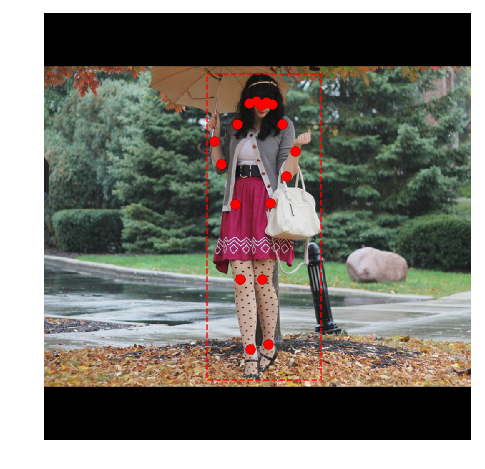

In [4]:
# Load a test image
image_id = dataset_val.image_ids[10]

# Get ground truth masks and bboxes
image, image_meta, gt_class_ids, gt_kp_ids, gt_bbox, gt_kp_masks = \
    modellib.load_image_gt(dataset_val, inference_config, image_id)

masks = utils.sparse_to_dense_masks(gt_kp_masks, image.shape)

log("image", image)
log("gt_class_ids", gt_class_ids)
log("gt_kp_ids", gt_kp_ids)
log("gt_bbox", gt_bbox)
log("gt_masks", gt_kp_masks)
log("masks", masks)


visualize.display_keypoints(image, gt_bbox, masks, gt_kp_ids,
                            #skeleton=dataset_val.skeleton,
                            figsize=(8, 8))

In [5]:
class TrainConfig(Config):
    NAME = "coco_keypoints"
    
    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1 # IMAGES_PER_GPU = 2
    GPU_COUNT = 1
    #MAX_GT_INSTANCES = 1
    
    # We use resnet50
    BACKBONE = "resnet50"
    
    # Set number of classes
    NUM_CLASSES = dataset_train.num_classes
    NUM_KEYPOINTS = dataset_train.num_kp_classes
    
    # DEBUG:
    STEPS_PER_EPOCH = 1
    VALIDATION_STEPS = 1
    
    TRAIN_ROIS_PER_IMAGE = 100
    
    RPN_NMS_THRESHOLD = 0.5
    
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024

config = TrainConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9

In [6]:
importlib.reload(modellib)

# Create model
print("Creating model...")
model = modellib.MaskRCNN(mode="training", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True,
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
    
# Do a quick forward pass
#print("Training network heads...")
#model.train(dataset_train, dataset_val,
#            learning_rate=config.LEARNING_RATE,
#            epochs=10,
#            layers="heads",
#            augmentation=None)

Creating model...

build:
input_gt_boxes.shape (?, ?, 4)
input_gt_kp_ids.shape (?, ?, 17)
input_gt_masks.shape (?, ?, 17)
target_mask.shape (1, ?, ?, ?)
target_mask.dtype <dtype: 'int32'>
fpn_classifier_graph:
x.shape (?, 100, 1, 1, 1024)

Level 0 (?, ?, ?, 256)
Level 1 (?, ?, ?, 256)
Level 2 (?, ?, ?, 256)
Level 3 (?, ?, ?, 256)
build_fpn_mask_graph:
x.shape (1, ?, 14, 14, 256)
x.shape (?, 100, 14, 14, 256)
x.shape (?, 100, 14, 14, 256)
x.shape (?, 100, 14, 14, 256)
x.shape (?, 100, 14, 14, 256)
x.shape (?, 100, 28, 28, 256)
x.shape (?, 100, 28, 28, 17)
x.shape (?, 100, 17, 28, 28)

mrcnn_mask.shape (?, 100, 17, 28, 28)


In [7]:
[layer.name for layer in model.keras_model.layers]

['input_image',
 'zero_padding2d_1',
 'conv1',
 'bn_conv1',
 'activation_1',
 'max_pooling2d_1',
 'res2a_branch2a',
 'bn2a_branch2a',
 'activation_2',
 'res2a_branch2b',
 'bn2a_branch2b',
 'activation_3',
 'res2a_branch2c',
 'res2a_branch1',
 'bn2a_branch2c',
 'bn2a_branch1',
 'add_1',
 'res2a_out',
 'res2b_branch2a',
 'bn2b_branch2a',
 'activation_4',
 'res2b_branch2b',
 'bn2b_branch2b',
 'activation_5',
 'res2b_branch2c',
 'bn2b_branch2c',
 'add_2',
 'res2b_out',
 'res2c_branch2a',
 'bn2c_branch2a',
 'activation_6',
 'res2c_branch2b',
 'bn2c_branch2b',
 'activation_7',
 'res2c_branch2c',
 'bn2c_branch2c',
 'add_3',
 'res2c_out',
 'res3a_branch2a',
 'bn3a_branch2a',
 'activation_8',
 'res3a_branch2b',
 'bn3a_branch2b',
 'activation_9',
 'res3a_branch2c',
 'res3a_branch1',
 'bn3a_branch2c',
 'bn3a_branch1',
 'add_4',
 'res3a_out',
 'res3b_branch2a',
 'bn3b_branch2a',
 'activation_10',
 'res3b_branch2b',
 'bn3b_branch2b',
 'activation_11',
 'res3b_branch2c',
 'bn3b_branch2c',
 'add_5',


In [8]:
import itertools

# Get example inputs
i = 5
val_generator = modellib.data_generator(dataset_val, config, shuffle=False, batch_size=config.BATCH_SIZE)
inputs, _ = next(itertools.islice(val_generator, i, i + 1))

In [9]:
from keras.models import Model
def get_intermediate_tensor(name, inputs):
    intermediate_layer_model = Model(inputs=model.keras_model.input,
                                     outputs=model.keras_model.get_layer(name).output)
    return intermediate_layer_model.predict(inputs)

## Verify Inputs

In [10]:
input_image = get_intermediate_tensor("input_image", inputs)
input_image_id = int(get_intermediate_tensor("input_image_meta", inputs)[0][0])
rois, target_class_ids, target_kp_ids, target_bbox, target_mask = \
    get_intermediate_tensor("proposal_targets", inputs)

print("Image ID = %i" % input_image_id)
log("input_image", input_image)
log("rois", rois)
log("target_class_ids", target_class_ids)
log("target_kp_ids", target_kp_ids)
log("target_bbox", target_bbox)
log("target_mask", target_mask)

Image ID = 5
input_image              shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10001  float32
rois                     shape: (1, 100, 4)           min:    0.00000  max:    0.97781  float32
target_class_ids         shape: (1, 100)              min:    0.00000  max:    1.00000  int32
target_kp_ids            shape: (1, 100, 17)          min:    0.00000  max:   17.00000  int32
target_bbox              shape: (1, 100, 4)           min:   -2.33561  max:    1.84358  float32
target_mask              shape: (1, 100, 17, 2)       min:  -68.00000  max:   31.00000  int32


### Input Image

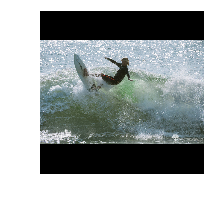

In [11]:
image = modellib.unmold_image(input_image[0], config)
visualize.display_images([image])

### Target ROIs

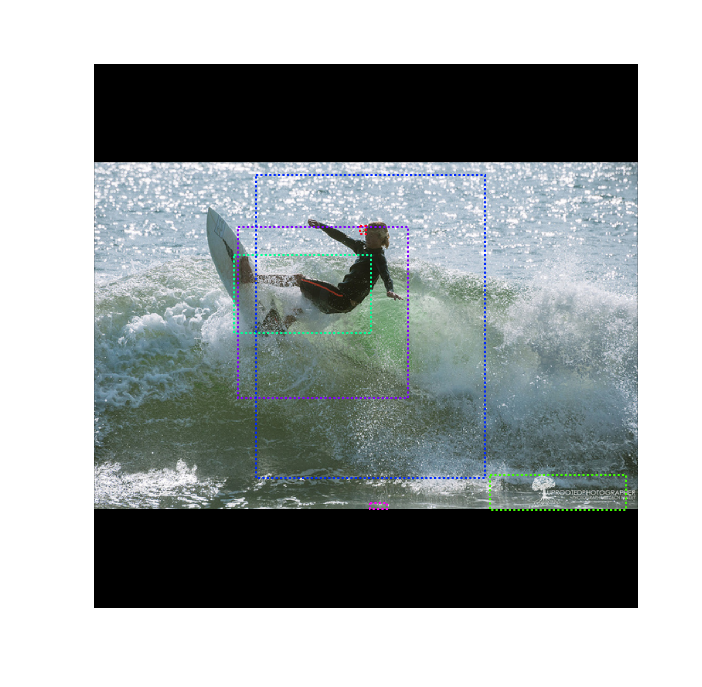

In [12]:
rois_int = rois[0].copy()
rois_int[:, 0] *= config.IMAGE_SHAPE[0]
rois_int[:, 1] *= config.IMAGE_SHAPE[1]
rois_int[:, 2] *= config.IMAGE_SHAPE[0]
rois_int[:, 3] *= config.IMAGE_SHAPE[1]
rois_int = rois_int.astype(np.int32)
visualize.draw_boxes(image, boxes=rois_int)

### Target Class Ids

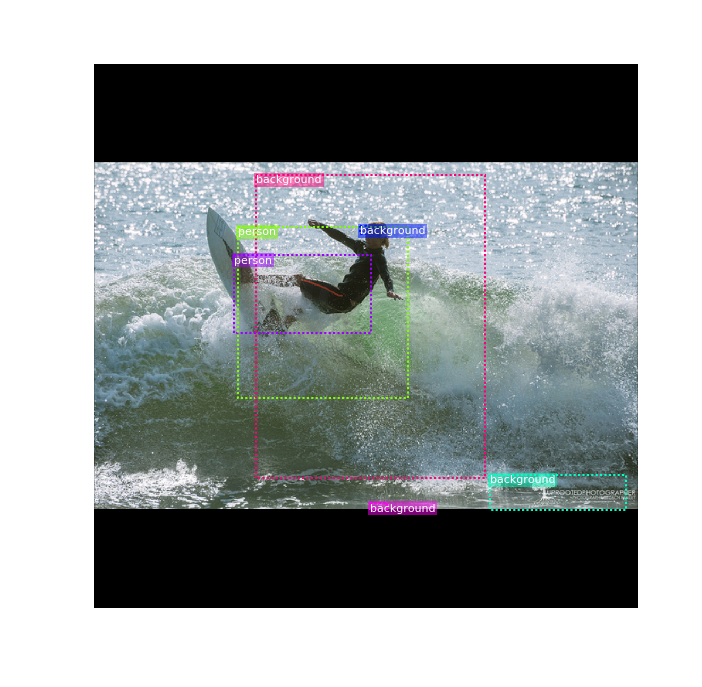

In [13]:
captions = ["person" if i == 1 else "background" for i in target_class_ids[0]]
visualize.draw_boxes(image, boxes=rois_int, captions=captions)

### Target Keypoint Masks

#### Show Steps of Expected Transformation Process

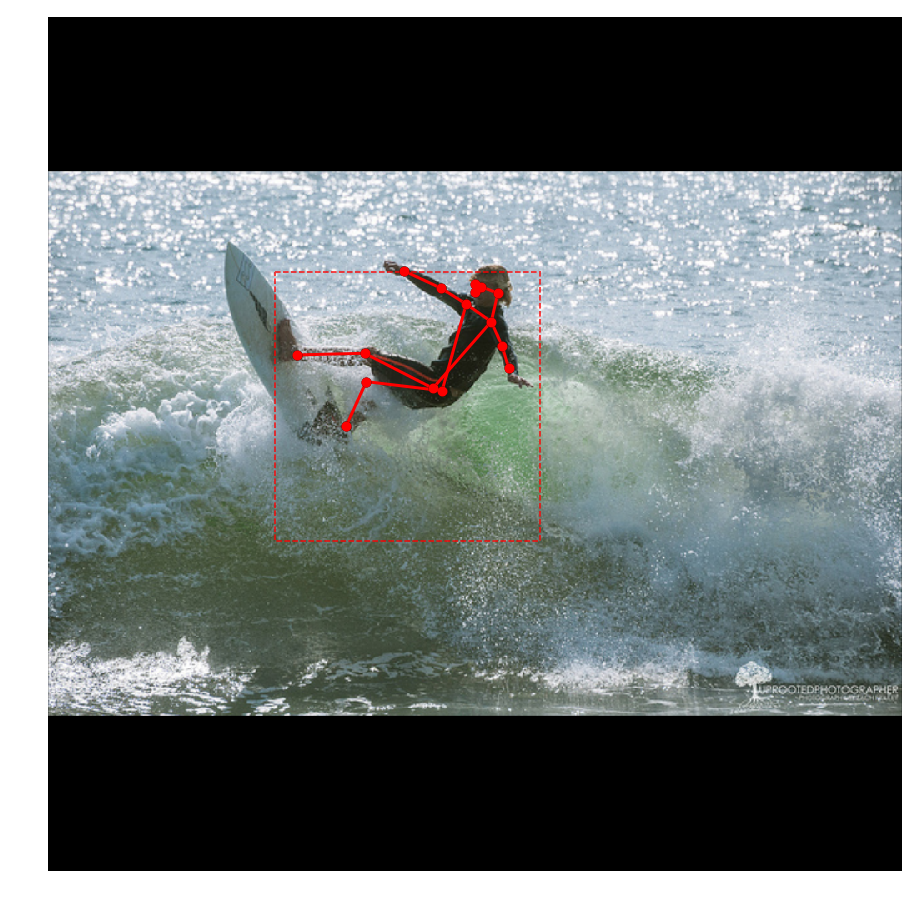

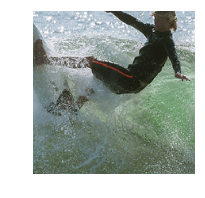

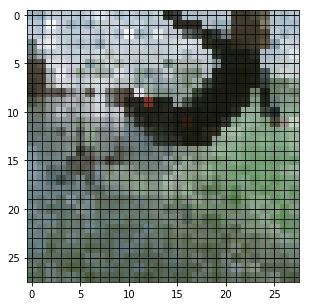

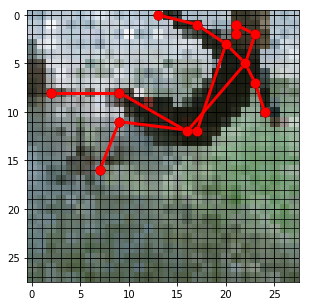

In [14]:
# Get ground truth masks and bboxes
image, image_meta, gt_class_ids, gt_kp_ids, _, gt_kp_masks = \
    modellib.load_image_gt(dataset_val, inference_config, input_image_id)
    
bbox = rois_int[1:2]

visualize.display_keypoints(image, bbox, utils.sparse_to_dense_masks(gt_kp_masks, image.shape), gt_kp_ids,
                            skeleton=dataset_val.skeleton)
    
# This function should be identical to the process that
# the network does to find the resized target masks
def resize_sparse_mask_to_roi(gt_kp_masks, gt_bbox):
    boxes_int = gt_bbox
    boxes = boxes_int.astype(np.float32)
    boxes[:, 0] /= config.IMAGE_SHAPE[0]
    boxes[:, 1] /= config.IMAGE_SHAPE[1]
    boxes[:, 2] /= config.IMAGE_SHAPE[0]
    boxes[:, 3] /= config.IMAGE_SHAPE[1]

    mask_shape = gt_kp_masks.shape
    kps_1d_indices = np.reshape(gt_kp_masks, (-1,))
    kps_y = (kps_1d_indices // config.IMAGE_SHAPE[1]).astype(np.float32)
    kps_x = np.mod(kps_1d_indices, config.IMAGE_SHAPE[1]).astype(np.float32)

    # Normalize x, y to image [0, 1] coords
    # [N x NUM_KEYPOINTS]
    kps_y = kps_y / config.IMAGE_SHAPE[0]
    kps_x = kps_x / config.IMAGE_SHAPE[1]

    # Reshape to per keypoint
    # [N, NUM_KEYPOINTS]
    kps_y = np.reshape(kps_y, (mask_shape[0], mask_shape[1],))
    kps_x = np.reshape(kps_x, (mask_shape[0], mask_shape[1],))

    # Normalize x, y to image [0, 1] coords
    # [N, (y1, x1, y2, x2), 1]
    boxes = np.expand_dims(boxes, axis=2)
    kps_y = kps_y - boxes[:, 0]
    kps_x = kps_x - boxes[:, 1]
    
    # Calculate corresponding position in resized mask
    # [N, NUM_KEYPOINTS]
    resized_kps_y = ((kps_y / (boxes[:, 2] - boxes[:, 0])) * config.MASK_SHAPE[0]).astype(np.int32)
    resized_kps_x = ((kps_x / (boxes[:, 3] - boxes[:, 1])) * config.MASK_SHAPE[1]).astype(np.int32)

    return np.stack([resized_kps_y, resized_kps_x], axis=2)

# Plot extracted roi
y1, x1, y2, x2 = bbox[0]
image_extract = image[y1:y2, x1:x2]
visualize.display_images([image_extract])

# Plot resized extracted roi
%matplotlib inline
import skimage.transform
import matplotlib.pyplot as plt
import matplotlib.ticker

image_extract_resize = skimage.transform.resize(image_extract, (config.MASK_SHAPE))

plt.figure(figsize=(5, 5))
plt.imshow(image_extract_resize,'gray',vmin=-1,vmax=1)
plt.minorticks_on()
plt.gca().xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
plt.gca().yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
plt.grid(which="both", linewidth=0.72, color="k")
plt.tick_params(which="minor", length=0)
plt.show()

# Calculate resized target masks for a given roi
gt_target_mask = resize_sparse_mask_to_roi(gt_kp_masks, bbox)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
visualize.display_keypoints(image_extract_resize, gt_bbox, gt_target_mask, gt_kp_ids,
                            skeleton=dataset_val.skeleton,
                            ax=ax)
ax.axis("on")
ax.minorticks_on()
ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
ax.grid(which="both", linewidth=0.72, color="k")
ax.tick_params(which="minor", length=0)
ax.set_xlim(-0.5, config.MASK_SHAPE[1] - 0.5)
ax.set_ylim(config.MASK_SHAPE[0] - 0.5, -0.5)
plt.show()

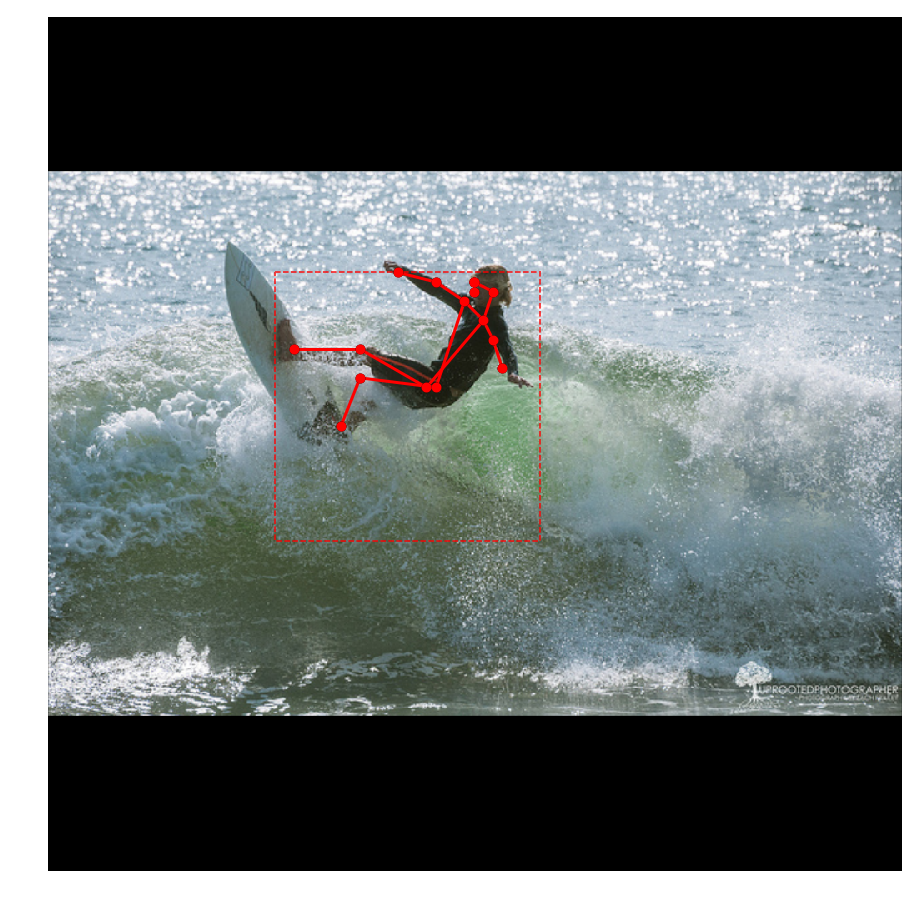

In [15]:
kp_masks = gt_target_mask.astype(np.float32)

bbox_norm = bbox.astype(np.float32)
bbox_norm[:, 0] /= config.IMAGE_SHAPE[0]
bbox_norm[:, 1] /= config.IMAGE_SHAPE[1]
bbox_norm[:, 2] /= config.IMAGE_SHAPE[0]
bbox_norm[:, 3] /= config.IMAGE_SHAPE[1]

# Normalize to mask-relative coords
kp_masks[:, :, 0] /= config.MASK_SHAPE[0]
kp_masks[:, :, 1] /= config.MASK_SHAPE[1]

boxes_dim = np.expand_dims(bbox_norm, axis=2)

kp_masks[:, :, 0] *= boxes_dim[:, 2] - boxes_dim[:, 0]
kp_masks[:, :, 1] *= boxes_dim[:, 3] - boxes_dim[:, 1]

kp_masks[:, :, 0] += boxes_dim[:, 0]
kp_masks[:, :, 1] += boxes_dim[:, 1]

kp_masks[:, :, 0] *= config.IMAGE_SHAPE[0]
kp_masks[:, :, 1] *= config.IMAGE_SHAPE[1]

visualize.display_keypoints(image, bbox, kp_masks, gt_kp_ids,
                            skeleton=dataset_val.skeleton)

#### Show Actual Generated Target Masks

Mask difference: 2


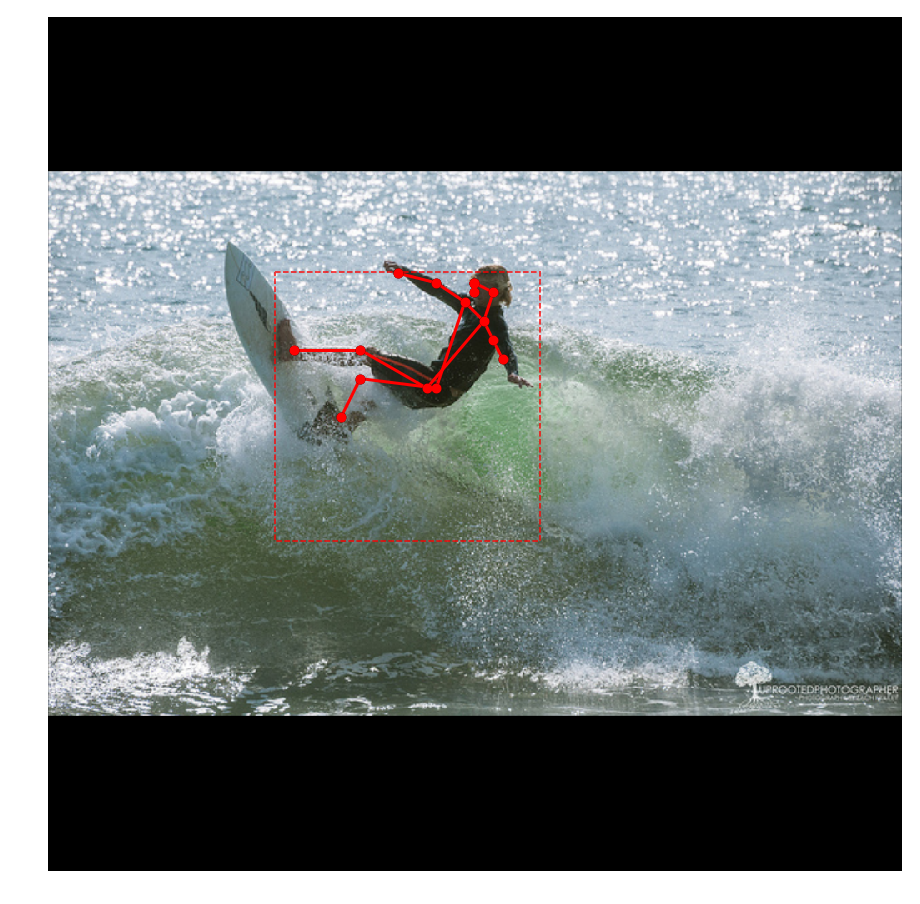

In [16]:
kp_masks = target_mask[0]
kp_ids = target_kp_ids[0]

kp_masks = kp_masks.astype(np.float32)

# Normalize to mask-relative coords
kp_masks[:, :, 0] /= config.MASK_SHAPE[0]
kp_masks[:, :, 1] /= config.MASK_SHAPE[1]

boxes_dim = np.expand_dims(rois[0], axis=2)

kp_masks[:, :, 0] *= boxes_dim[:, 2] - boxes_dim[:, 0]
kp_masks[:, :, 1] *= boxes_dim[:, 3] - boxes_dim[:, 1]

kp_masks[:, :, 0] += boxes_dim[:, 0]
kp_masks[:, :, 1] += boxes_dim[:, 1]

kp_masks[:, :, 0] *= config.IMAGE_SHAPE[0]
kp_masks[:, :, 1] *= config.IMAGE_SHAPE[1]

print("Mask difference:", np.sum(np.abs(target_mask[0, 1:2] - gt_target_mask)))

visualize.display_keypoints(image, rois_int[1:2], kp_masks[1:2], kp_ids[1:2],
                            skeleton=dataset_val.skeleton)

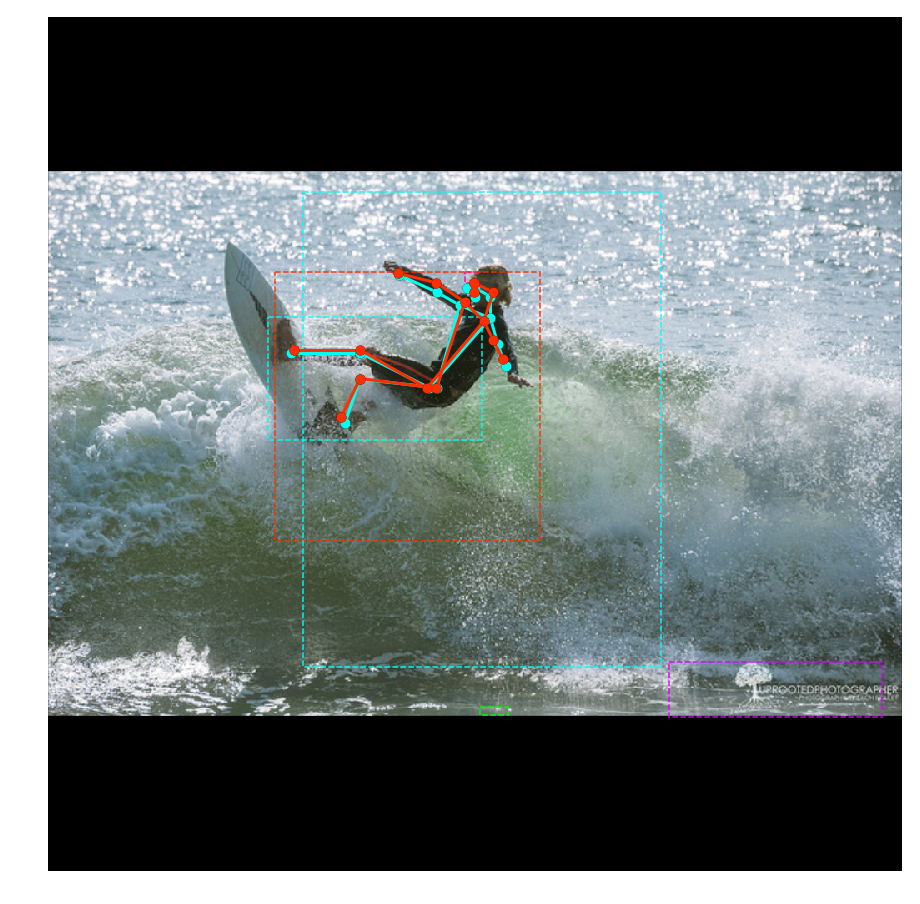

In [17]:
kp_masks = target_mask[0]
kp_ids = target_kp_ids[0]

kp_masks = kp_masks.astype(np.float32)

# Normalize to mask-relative coords
kp_masks[:, :, 0] /= config.MASK_SHAPE[0]
kp_masks[:, :, 1] /= config.MASK_SHAPE[1]

boxes_dim = np.expand_dims(rois[0], axis=2)

kp_masks[:, :, 0] *= boxes_dim[:, 2] - boxes_dim[:, 0]
kp_masks[:, :, 1] *= boxes_dim[:, 3] - boxes_dim[:, 1]

kp_masks[:, :, 0] += boxes_dim[:, 0]
kp_masks[:, :, 1] += boxes_dim[:, 1]

kp_masks[:, :, 0] *= config.IMAGE_SHAPE[0]
kp_masks[:, :, 1] *= config.IMAGE_SHAPE[1]

importlib.reload(visualize)

visualize.display_keypoints(image, rois_int, kp_masks, kp_ids,
                            skeleton=dataset_val.skeleton)

## Get Predicted Masks

TypeError: Invalid dimensions for image data

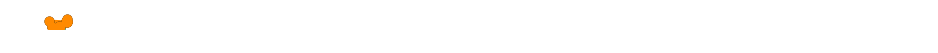

In [18]:
mrcnn_mask = get_intermediate_tensor("mrcnn_mask", inputs)
visualize.display_keypoints(input_image, rois_int, mrcnn_mask[0], target_kp_ids[0],
                            skeleton=dataset_val.skeleton)

In [ ]:
def plot_grid(images, titles=None):
    n = np.sqrt(len(images))
    _, axes = plt.subplots(int(np.ceil(n)), int(np.floor(n)), figsize=(15, 15))
    if n <= 1: axes = np.array(axes)
    for i, ax in enumerate(axes.flatten()):
        ax.axis("off")
        if i >= inference_config.NUM_KEYPOINTS: continue    
        if titles is not None:
            ax.set_title(titles[i])
        ax.imshow(images[i])
    plt.show()

plot_grid(mrcnn_mask[0, 0], titles=dataset_val.kp_class_names[1:])